Alpha_Vantage Tutorial & Examples
=================================

Uses RomelTorres' API wrapper from Github.

TimeSeries
----------

Used to get price data over a time frame. Defaults to integer, though
pandas df is more useful. Extended or adjusted pricing data (adjusts
prices retroactively for splits & dividends).


In [1]:
import datetime
import json
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.fundamentaldata import FundamentalData

# initialize av API
AV_API_KEY = 'AIDD24S6AW4MOOHG'

TimeSeries defaults to returning 2 .json files: data & metadata, but
using `output_format='pandas'` returns as pandas df instead of .json.
`outputsize` kwarg defaults to `'compact'`, which returns last 100
values, but setting to `'full'` returns all available data rows (>1 MB
file sizes).

            1. open  2. high  3. low  4. close  5. adjusted close   6. volume  \
date                                                                            
2021-01-08    84.37   84.370   82.55     83.03          83.030000   9125149.0   
2021-01-07    82.55   84.370   82.07     84.02          84.020000   9969438.0   
2021-01-06    80.58   82.737   80.31     82.38          82.380000  10039525.0   
2021-01-05    80.67   81.395   79.91     81.10          81.100000  10454680.0   
2021-01-04    82.00   82.090   79.88     80.96          80.960000  10021557.0   
...             ...      ...     ...       ...                ...         ...   
1999-11-05    79.94   81.130   79.50     80.38          36.754245   3816200.0   
1999-11-04    79.56   80.690   79.06     79.69          36.438738   4144900.0   
1999-11-03    79.44   80.880   78.75     79.13          36.182675   4428900.0   
1999-11-02    79.56   80.190   78.00     78.06          35.693411   3186000.0   
1999-11-01    78.94   79.940

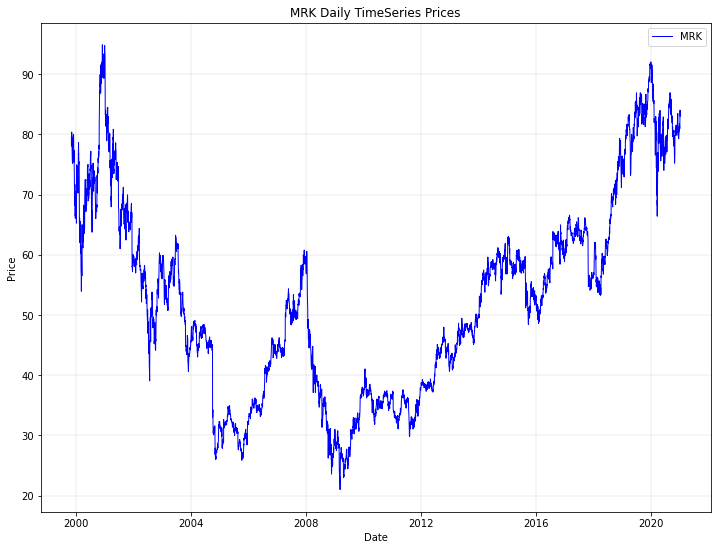

In [2]:
# Create MRK pandas df.
# type(mrk_ts_data) = pd.Dataframe & type(mrk_ts_metadata) = dict
ts = TimeSeries(key=AV_API_KEY, output_format='pandas')
mrk_ts_data, mrk_ts_metadata = ts.get_daily_adjusted('MRK',
                                                     outputsize='full')
metadata = pd.Series(mrk_ts_metadata, name='Metadata')  # metadata dict->Series
print(mrk_ts_data)

# Plot daily closing prices for MRK.
mrk_ts_fig, mrk_ts_ax = plt.subplots(figsize=(12, 9))
mrk_ts_ax.plot(
    mrk_ts_data.index,  # Series for x-axis values
    mrk_ts_data['4. close'],  # Series of f(x) values
    '-b',  # solid blue lines, no individual markers
    linewidth=1,
    label='MRK'  # label in legend
)
mrk_ts_ax.set_title('MRK Daily TimeSeries Prices')
mrk_ts_ax.set_xlabel('Date')
mrk_ts_ax.set_ylabel('Price')
mrk_ts_ax.grid(b=True, linestyle='-', linewidth=0.25)
mrk_ts_ax.legend()

In [3]:
# Get daily MRK close & adj close prices from 2020-01-21 (COVID crash
# date) thru yesterday.
yesterday_date = pd.datetime.now().date() - pd.Timedelta('1 days')
print(yesterday_date)

# Get df of close & adj-close prices for the dates.
# NOTE: date slice is in format [latest_data:earliest_date] since dates
# in df are in order of latest-date-1st
covid_data = mrk_ts_data.loc[
    yesterday_date: pd.Timestamp('2020-01-21'),
    ['4. close', '5. adjusted close']
]

2021-01-09


<ipython-input-3-443cd75a6786>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  yesterday_date = pd.datetime.now().date() - pd.Timedelta('1 days')


{'1. Information': 'Daily Time Series with Splits and Dividend Events', '2. Symbol': 'MRK', '3. Last Refreshed': '2021-01-08', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}


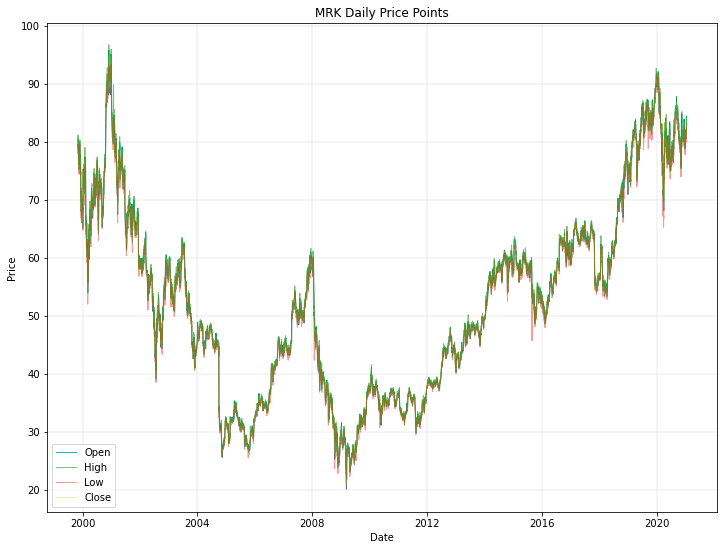

In [4]:
# Check MRK metadata.
print(mrk_ts_metadata)

# Plot MRK open/close/hi/lo.
mrk_ts_fig, mrk_ts_ax = plt.subplots(figsize=(12, 9))
mrk_ts_ax.plot(
    # Plot daily open prices.
    mrk_ts_data.index,
    mrk_ts_data['1. open'],
    '-c',  # solid cyan line
    linewidth=1,
    label='Open'
)
mrk_ts_ax.plot(
    # Plot daily high prices.
    mrk_ts_data.index,
    mrk_ts_data['2. high'],
    '-g',  # solid green line
    linewidth=1,
    alpha=0.51,
    label='High'
)
mrk_ts_ax.plot(
    # Plot daily low prices.
    mrk_ts_data.index,
    mrk_ts_data['3. low'],
    '-r',  # solid red line
    linewidth=1,
    alpha=0.4,
    label='Low'
)
mrk_ts_ax.plot(
    # Plot daily close prides.
    mrk_ts_data.index,
    mrk_ts_data['4. close'],
    '-y',  # solid yellow line
    linewidth=1,
    alpha=0.3,
    label='Close'
)
mrk_ts_ax.set_title('MRK Daily Price Points')
mrk_ts_ax.set_xlabel('Date')
mrk_ts_ax.set_ylabel('Price')
mrk_ts_ax.grid(b=True, linestyle='-', linewidth=0.25)
mrk_ts_ax.legend()

Tech Indicators
---------------

Example uses Bollinger Bands (BBands). These consist of 3 trends lines:
an upper, middle, & lower.

* middle band = SMA

* upper band = SMA + 2*SD

* lower band = SMA - 2*SD

A narrower split b/w upper & lower bands (a **"squeeze"**) represents
lower volatility & a narrower 95% CI, & *may* represent future increases
in volatility. A wider split b/w upper & lower bands represents higher
volatility & a wider 95% CI, & *may* represent future decreases in
volatility.

In [5]:
# BBands tech indicators
ti = TechIndicators(AV_API_KEY, output_format='pandas')
mrk_ti_data, mrk_ti_metadata = ti.get_bbands(
    symbol='MRK',
    interval='daily',  # interval b/w consecutive values
    # Number of intervals to avg over, e.g. 90 = 90-day sliding avg.
    time_period=90
)
print(mrk_ti_data.describe())
print(mrk_ti_data)

       Real Upper Band  Real Middle Band  Real Lower Band
count      5243.000000       5243.000000      5243.000000
mean         41.019754         37.484855        33.949957
std          18.749329         17.723607        16.847759
min          17.916000         16.187400        10.673500
25%          27.086750         24.765500        22.042900
50%          35.218800         31.142600        27.862900
75%          51.442950         48.632750        45.364000
max          93.899700         83.895400        78.304000
            Real Upper Band  Real Middle Band  Real Lower Band
date                                                          
2021-01-08          84.9461           80.6170          76.2880
2021-01-07          84.9845           80.6275          76.2706
2021-01-06          85.0002           80.6312          76.2623
2021-01-05          85.0846           80.6550          76.2254
2021-01-04          85.1821           80.6899          76.1977
...                     ...          

In [6]:
# View metadata as Series
mrk_ti_metadata = pd.Series(mrk_ti_metadata, name='Metadata')
print(mrk_ti_metadata)

1: Symbol                                                        MRK
2: Indicator                                Bollinger Bands (BBANDS)
3: Last Refreshed                                         2021-01-08
4: Interval                                                    daily
5: Time Period                                                    90
6.1: Deviation multiplier for upper band                           2
6.2: Deviation multiplier for lower band                           2
6.3: MA Type                                                       0
7: Series Type                                                 close
8: Time Zone                                         US/Eastern Time
Name: Metadata, dtype: object


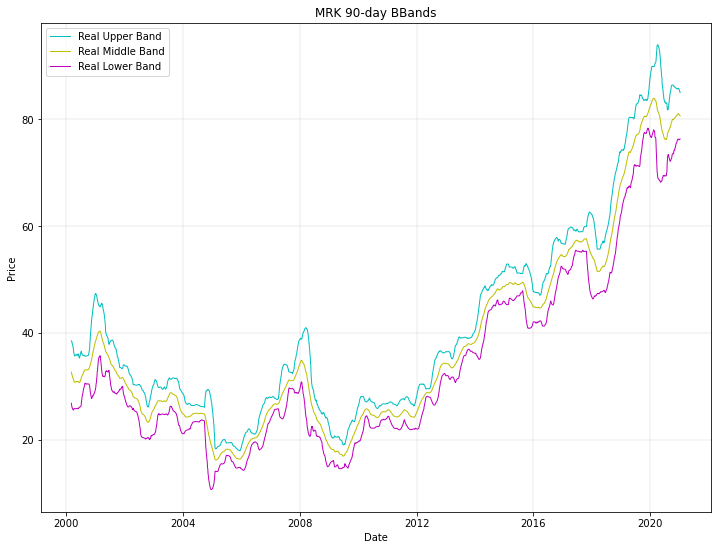

In [7]:
mrk_ti_fig = plt.figure(figsize=(12, 9))
gs = mrk_ti_fig.add_gridspec(nrows=1, ncols=1)  # 1x1 set of axes

# Create subplot at specified coords & assign to axis
mrk_ti_ax = mrk_ti_fig.add_subplot(gs[0,0])
mrk_ti_ax.plot(
    # Plot daily open prices.
    mrk_ti_data.index,
    mrk_ti_data['Real Upper Band'],
    '-c',
    linewidth=1,
    label='Real Upper Band'
)
mrk_ti_ax.plot(
    # Plot daily open prices.
    mrk_ti_data.index,
    mrk_ti_data['Real Middle Band'],
    '-y',
    linewidth=1,
    label='Real Middle Band'
)
mrk_ti_ax.plot(
    # Plot daily open prices.
    mrk_ti_data.index,
    mrk_ti_data['Real Lower Band'],
    '-m',
    linewidth=1,
    label='Real Lower Band'
)
mrk_ti_ax.set_title('MRK 90-day BBands')
mrk_ti_ax.set_xlabel('Date')
mrk_ti_ax.set_ylabel('Price')
mrk_ti_ax.grid(b=True, linestyle='-', linewidth=0.25)
mrk_ti_ax.legend()

Sector Performance
==================

Returns performance of all market sectors based on performance of
S&P500 members in terms of growth % since beginning of time period.

Information       US Sector Performance (realtime & historical)
Last Refreshed                   2021-01-10 09:26:02 US/Eastern
Name: Metadata, dtype: object
                        Rank A: Real-Time Performance  \
Consumer Discretionary                         0.0180   
Real Estate                                    0.0109   
Utilities                                      0.0087   
Information Technology                         0.0075   
Consumer Staples                               0.0050   
Health Care                                    0.0047   
Communication Services                         0.0025   
Energy                                        -0.0009   
Financials                                    -0.0019   
Industrials                                   -0.0022   
Materials                                     -0.0051   

                        Rank B: 1 Day Performance  Rank C: 5 Day Performance  \
Consumer Discretionary                     0.0180                     0.0384 

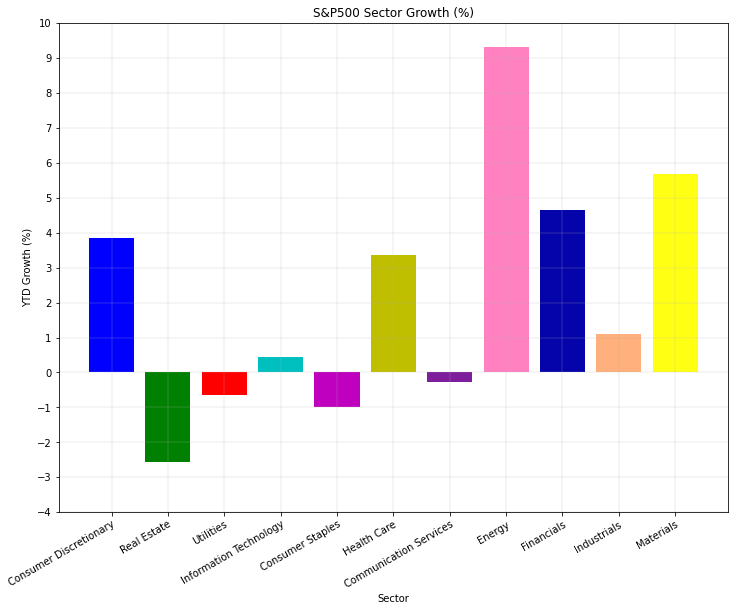

In [8]:
# Initialize sector performances.
sp = SectorPerformances(key=AV_API_KEY, output_format='pandas')
sp_data, sp_metadata = sp.get_sector()
sp_metadata = pd.Series(sp_metadata, name='Metadata')  # metadata as df

# sectorperformance.py pkg code is dropping the numbers from df column
# names, so rename sp_data columns.
sp_data = sp_data.rename(
    columns={
        'Rank B: Day Performance': 'Rank B: 1 Day Performance',
        'Rank C: Day Performance': 'Rank C: 5 Day Performance',
        'Rank D: Month Performance': 'Rank D: 1 Month Performance',
        'Rank E: Month Performance': 'Rank E: 3 Month Performance',
        'Rank G: Year Performance': 'Rank G: 1 Year Performance',
        'Rank H: Year Performance': 'Rank H: 3 Year Performance',
        'Rank I: Year Performance': 'Rank I: 5 Year Performance',
        'Rank J: Year Performance': 'Rank J: 10 Year Performance'
    }
)

# Check df.
print(sp_metadata)
print(sp_data)

# Make bar graph of sectors' YTD % growth
sp_fig = plt.figure(figsize=(12, 9))
sp_ax = sp_fig.add_subplot(sp_fig.add_gridspec(nrows=1, ncols=1)[0, 0])
sp_ax.bar(
    sp_data.index,
    sp_data['Rank F: Year-to-Date (YTD) Performance'] * 100,
    color=['b', 'g', 'r', 'c', 'm', 'y', 'xkcd:purple', 'xkcd:pink',
           'xkcd:royal blue', 'xkcd:peach', 'xkcd:yellow']
)
# Should make function to get bar graph ylim
ymin = np.around(
    np.min([
        0,
        -1 * (1 + 100*np.abs(
            sp_data['Rank F: Year-to-Date (YTD) Performance'].min()))
    ]),
    decimals=0)
ymax = np.around(
    (1 + 100*sp_data['Rank F: Year-to-Date (YTD) Performance'].max()),
    decimals=0)

sp_ax.set_title('S&P500 Sector Growth (%)')
sp_ax.set_xlabel('Sector')

# Rotate x-ticks labels to 45 deg.
sp_ax.set_xticks(sp_ax.get_xticks())
sp_ax.set_xticklabels(
    sp_data.index,
    rotation=30,
    ha='right',
    wrap=True
)

sp_ax.set_ylabel('YTD Growth (%)')
sp_ax.set_ylim(bottom=ymin, top=ymax)
sp_ax.set_yticks(np.arange(sp_ax.get_ylim()[0],
                           sp_ax.get_ylim()[1] + 1))
sp_ax.grid(b=True, linestyle='-', linewidth=0.25)


Stock Fundamentals
==================

Gets following reports for a given stock:

### overview

* `fd.get_company_overview(symbol)`

### income statements

* annual -- `fd.get_income_statement_annual(symbol)`

* quarterly -- `fd.get_income_statement_quarterly(symbol)`

### balance sheets

* annual -- `fd.get_income_statement_annual(symbol)`

* quarterly -- `fd.get_income_statement_quarterly(symbol)`

### cash flow

* annual -- `fd.get_cash_flow_annual(symbol)`

* quarterly -- `fd.get_cash_flow_quarterly(symbol)`


### Fundamental Data

`fd.get_company_overview()` returns a tuple consisting of a dict of
company info, only some of which is useful in an overview_data df. It
appears easier to return as a .json, then unpack the dict manually into
both a df for both data & metadata.

In [15]:
fd = FundamentalData(key=AV_API_KEY, output_format='json')

# step-by-step
mrk_overview_tuple = fd.get_company_overview('MRK')
mrk_overview_dict = mrk_overview_tuple[0]
mrk_overview = pd.Series(mrk_overview_dict)
print(mrk_overview)

# 1-step
mrk_overview = pd.Series(
    FundamentalData(
        key=AV_API_KEY, output_format='json'
    ).get_company_overview('MRK')[0]
)

# metadata Series
mrk_overview_metadata = mrk_overview[[
    'Symbol',
    'Name',
    'Description',
    'Address',
    'AssetType',
    'Currency',
    'Country',
    'Exchange',
    'Sector',
    'Industry',
    'FullTimeEmployees',
    'FiscalYearEnd',
    'LatestQuarter'
]]
mrk_overview_metadata.index = [
    'Symbol',
    'Name',
    'Description',
    'Address',
    'Equity Type',
    'Currency',
    'Country',
    'Exchange',
    'Sector',
    'Industry',
    'Full-time Employees',
    'FY End',
    'Latest Quarter'
]
mrk_overview_metadata.name = 'MRK Metadata'
print(mrk_overview_metadata)

# data Series
mrk_overview_data = mrk_overview.drop(labels=[
    'Symbol',
    'Name',
    'Description',
    'Address',
    'AssetType',
    'Currency',
    'Country',
    'Exchange',
    'Sector',
    'Industry',
    'FullTimeEmployees',
    'FiscalYearEnd',
    'LatestQuarter'
])
mrk_overview_data.index = [
    'Market Cap', 'EBITDA', 'P/E', 'PEG', 'Book Value', 'DPS',
    'Div Yield', 'EPS', 'TTM RPS', 'Net Profit Margin', 'TTM Op Margin', 'TTM ROA',
    'TTM ROE', 'TTM Rev', 'TTM Gross Profit', 'TTM Diluted EPS',
    'YOY Q Earnings Growth', 'YOY Q Rev Growth', 'Analyst Target Price', 'Trailing P/E', 'Forward P/E', 'TTM P/S',
    'P/B', 'EV/Rev', 'EV/EBITDA', 'Beta', '52 Wk High', '52 Wk Low',
    'SMA50', 'SMA200', 'Shares Outstanding', 'Shares Float',
    'Shares Short', 'Shares Short Prior Month', 'Short Ratio',
    'Short % Outstanding', 'Short % Float', '% Insiders',
    '% Institutions', 'Forward Annual Div Rate',
    'Forward Annual Div Yield', 'Payout Ratio', 'Div Date',
    'Ex-Div Date', 'Last Split Factor', 'Last Split Date'
]
mrk_overview_data.name = mrk_overview_metadata['Symbol']
print(mrk_overview_data)



Symbol                                                                      MRK
AssetType                                                          Common Stock
Name                                                           Merck & Co., Inc
Description                   Merck & Co., Inc. provides healthcare solution...
Exchange                                                                   NYSE
Currency                                                                    USD
Country                                                                     USA
Sector                                                               Healthcare
Industry                                             Drug Manufacturers-General
Address                       2000 Galloping Hill Road, Kenilworth, NJ, Unit...
FullTimeEmployees                                                         71000
FiscalYearEnd                                                          December
LatestQuarter                           